# histolab data qc

In [64]:
import os
data_path = '/lab/deasylab3/Jung/tiger/'
dir_TIFF_images = data_path + "/wsirois/wsi-level-annotations/images/"


imgs_names = os.listdir(dir_TIFF_images)
imgs_names.sort()

imgs_names = [i for i in imgs_names if i.startswith('TCGA')]    


In [65]:
import histolab

In [66]:
from PIL import Image
from histolab.filters.image_filters import (
    ApplyMaskImage,
    Compose,
    OtsuThreshold,
    RgbToGrayscale,
)
from histolab.filters.morphological_filters import BinaryDilation

def composed_filters(image_rgb):
    filters = Compose(
        [
            RgbToGrayscale(),
            OtsuThreshold(),
            BinaryDilation(),
            ApplyMaskImage(image_rgb),
        ]
    )
    return filters(image_rgb)

In [79]:
wsi_path = dir_TIFF_images + imgs_names[2]

In [80]:
wsi_path

'/lab/deasylab3/Jung/tiger//wsirois/wsi-level-annotations/images/TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FDD-6494E6EE2B71.tif'

In [81]:
from histolab.slide import Slide

In [82]:
import numpy as np
from histolab.slide import Slide
from histolab.masks import BinaryMask
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

class TissueMask(BinaryMask):
    def _mask(self, slide):
        # Read the thumbnail for quick mask estimation
        thumbnail = slide.thumbnail  # small RGB image
        gray = rgb2gray(thumbnail)  # convert to grayscale [0, 1]
        
        # Threshold using Otsu’s method
        thresh = threshold_otsu(gray)
        tissue_mask_thumb = gray < thresh  # tissue is usually darker

        # Resize mask to match slide dimensions
        from skimage.transform import resize
        full_mask = resize(
            tissue_mask_thumb.astype(np.uint8),
            slide.dimensions[::-1],  # (height, width)
            order=0, preserve_range=True, anti_aliasing=False
        ).astype(np.uint8)

        return full_mask



In [71]:
slide = Slide(wsi_path, processed_path="processed")

# Apply tissue mask
mask = TissueMask()
mask_array = mask(slide)

In [72]:
import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import resize

# Convert thumbnail to NumPy array
thumbnail = np.array(slide.thumbnail)

# Resize the binary mask to match thumbnail shape (height, width)
mask_resized = resize(
    mask_array,
    output_shape=thumbnail.shape[:2],  # (height, width)
    order=0,
    preserve_range=True,
    anti_aliasing=False
).astype(bool)


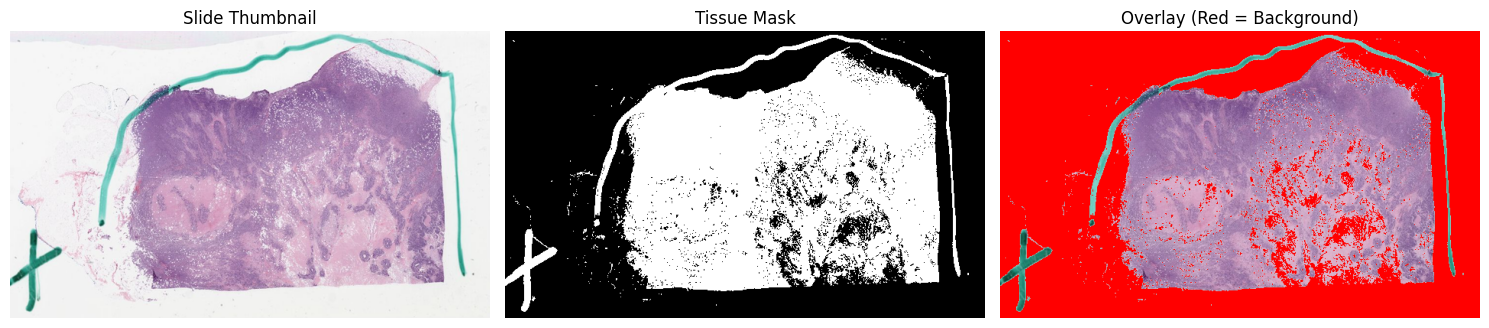

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original thumbnail
axes[0].imshow(thumbnail)
axes[0].set_title("Slide Thumbnail")
axes[0].axis("off")

# Mask only
axes[1].imshow(mask_resized, cmap="gray")
axes[1].set_title("Tissue Mask")
axes[1].axis("off")

# Overlay: red mask over thumbnail
overlay = thumbnail.copy()
overlay[~mask_resized] = [255, 0, 0]  # red background for non-tissue

axes[2].imshow(overlay)
axes[2].set_title("Overlay (Red = Background)")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [83]:
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import binary_dilation, remove_small_holes, remove_small_objects, disk
from histolab.masks import BinaryMask

class CustomTissueMask(BinaryMask):
    def _mask(self, slide):
        # Step 1: Get thumbnail and convert to grayscale
        thumb_rgb = np.array(slide.thumbnail)
        gray = rgb2gray(thumb_rgb)

        # Step 2: Otsu threshold
        thresh = threshold_otsu(gray)
        binary = gray < thresh  # darker = tissue

        # Step 3: Binary dilation
        dilated = binary_dilation(binary, selem=disk(3))

        # Step 4: Remove small holes
        no_holes = remove_small_holes(dilated, area_threshold=500)

        # Step 5: Remove small objects
        cleaned = remove_small_objects(no_holes, min_size=1000)

        # Step 6: Resize to full-resolution dimensions
        from skimage.transform import resize
        resized_mask = resize(
            cleaned.astype(np.uint8),
            slide.dimensions[::-1],  # (height, width)
            order=0, preserve_range=True, anti_aliasing=False
        ).astype(np.uint8)

        # Step 7: Return final binary mask
        return resized_mask


In [87]:
slide = Slide(wsi_path, processed_path="processed")
mask = CustomTissueMask()
final_mask = mask(slide)

/tmp/ipykernel_4132180/2760142076.py:18: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  dilated = binary_dilation(binary, selem=disk(3))


In [88]:
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label
import numpy as np

# Get slide thumbnail and convert to array
thumbnail = np.array(slide.thumbnail)

# Resize mask to thumbnail size
from skimage.transform import resize
mask_resized = resize(
    final_mask,
    thumbnail.shape[:2],  # (height, width)
    order=0,
    preserve_range=True,
    anti_aliasing=False
).astype(bool)

# Optional: Bounding box of largest tissue region
labeled = label(mask_resized)
props = regionprops(labeled)
if props:
    largest_region = max(props, key=lambda x: x.area)
    minr, minc, maxr, maxc = largest_region.bbox
else:
    minr = minc = maxr = maxc = 0


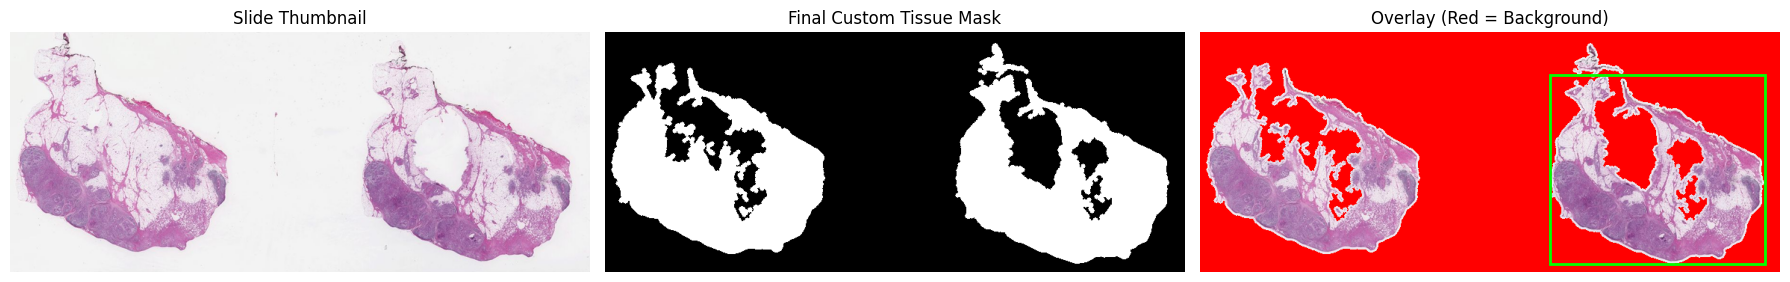

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Slide thumbnail
axes[0].imshow(thumbnail)
axes[0].set_title("Slide Thumbnail")
axes[0].axis("off")

# Final binary mask
axes[1].imshow(mask_resized, cmap="gray")
axes[1].set_title("Final Custom Tissue Mask")
axes[1].axis("off")

# Overlay
overlay = thumbnail.copy()
overlay[~mask_resized] = [255, 0, 0]  # red background
axes[2].imshow(overlay)
axes[2].set_title("Overlay (Red = Background)")
axes[2].axis("off")

# Optional: Draw bounding box on overlay
if maxr > minr and maxc > minc:
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                         edgecolor='lime', facecolor='none', linewidth=2)
    axes[2].add_patch(rect)

plt.tight_layout()
plt.show()


In [50]:
reader = Slide(wsi_path,processed_path="processed")


In [51]:
print(f"Slide name: {reader.name}")
print(f"Levels: {reader.levels}")
print(f"Dimensions at level 0: {reader.dimensions}")
print(f"Dimensions at level 1: {reader.level_dimensions(level=1)}")
print(f"Dimensions at level 2: {reader.level_dimensions(level=2)}")

Slide name: TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297
Levels: [0, 1, 2, 3, 4, 5, 6, 7]
Dimensions at level 0: (62876, 37539)
Dimensions at level 1: (31438, 18769)
Dimensions at level 2: (15719, 9384)


NameError: name 'mask_reader' is not defined

In [40]:
rect

In [90]:
from PIL import Image

# Step 1: Get full-resolution slide dimensions
W, H = slide.dimensions  # (width, height)

# Step 2: Convert thumbnail to NumPy and calculate scale
thumbnail = np.array(slide.thumbnail)
thumb_h, thumb_w = thumbnail.shape[:2]

scale_x = W / thumb_w
scale_y = H / thumb_h

# Step 3: Scale bounding box coords from thumbnail to slide
x_min = int(minc * scale_x)
y_min = int(minr * scale_y)
x_max = int(maxc * scale_x)
y_max = int(maxr * scale_y)




In [91]:
x_min,y_min,x_max,y_max

(46941, 5807, 75667, 31138)

In [41]:
W, H = slide.dimensions  # (width, height)

# Step 2: Create thumbnail and calculate scale
thumbnail = np.array(slide.get_thumbnail((1024, 1024)))  # Create a thumbnail of known size
thumb_h, thumb_w = thumbnail.shape[:2]

scale_x = W / thumb_w
scale_y = H / thumb_h

# Step 3: Example bounding box in thumbnail space (replace with actual values)
minc, minr, maxc, maxr = 100, 150, 400, 350  # These should be set by your application logic

# Step 4: Scale bounding box to full-res coordinates
x_min = int(minc * scale_x)
y_min = int(minr * scale_y)
x_max = int(maxc * scale_x)
y_max = int(maxr * scale_y)

# Step 5: Ensure ROI is within bounds
roi_width = max(1, x_max - x_min)
roi_height = max(1, y_max - y_min)

x_min = min(max(x_min, 0), W - roi_width)
y_min = min(max(y_min, 0), H - roi_height)

# Step 6: Extract ROI using read_region
roi_pil = slide.read_region(
    location=(x_min, y_min),
    level=0,
    size=(roi_width, roi_height)
).convert("RGB")  # Remove alpha

# Step 7: Save cropped image
roi_pil.save("roi_tissue_box.tif")

AttributeError: 'Slide' object has no attribute 'get_thumbnail'

In [42]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the full .tif image
img = Image.open("roi_tissue_box.tif")

# Create a thumbnail (in-place) - this doesn't modify the original image
thumbnail_size = (512, 512)  # or any small size you want
img.thumbnail(thumbnail_size)

# Show the thumbnail using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")
plt.title("Thumbnail of ROI")
plt.show()


/cluster/home/srivash/miniforge3/envs/histolab/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


UnidentifiedImageError: cannot identify image file '/lab/deasylab3/Himangi/TNBC_multimodal/roi_tissue_box.tif'

In [43]:
slide = Slide("roi_tissue_box.tif", processed_path="processed")

In [21]:
thumbnail = np.array(slide.thumbnail)

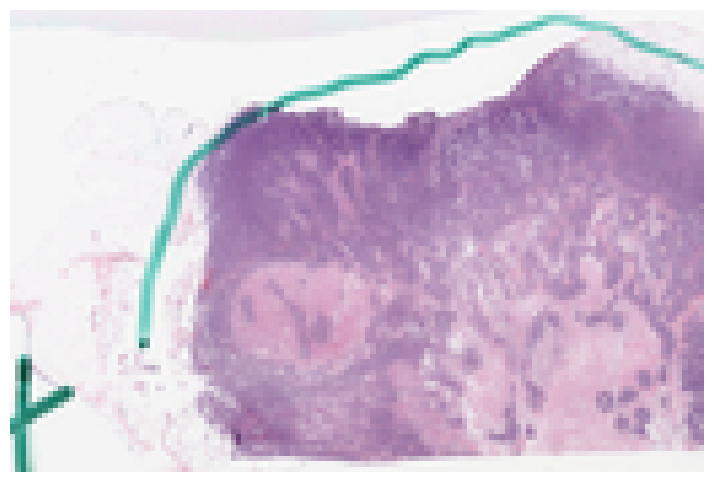

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

plt.imshow(thumbnail)
plt.axis("off")
plt.show()




In [57]:
from histolab.tiler import ScoreTiler
from histolab.scorer import NucleiScorer
from histolab.tiler import GridTiler
scored_tiles_extractor = ScoreTiler(
    scorer = NucleiScorer(),
    tile_size=(1024, 1024),
    n_tiles=100,
    level=0,
    check_tissue=True,
    tissue_percent=80.0,
    pixel_overlap=0, # default
    prefix="scored/", # save tiles in the "scored" subdirectory of slide's processed_path
    suffix=".png" # default
)

/cluster/home/srivash/miniforge3/envs/histolab/lib/python3.10/site-packages/histolab/filters/image_filters_functional.py:210: UserWarning: Input image must be RGB. NOTE: the image will be converted to RGB before HED conversion.
  hed = rgb_to_hed(img)


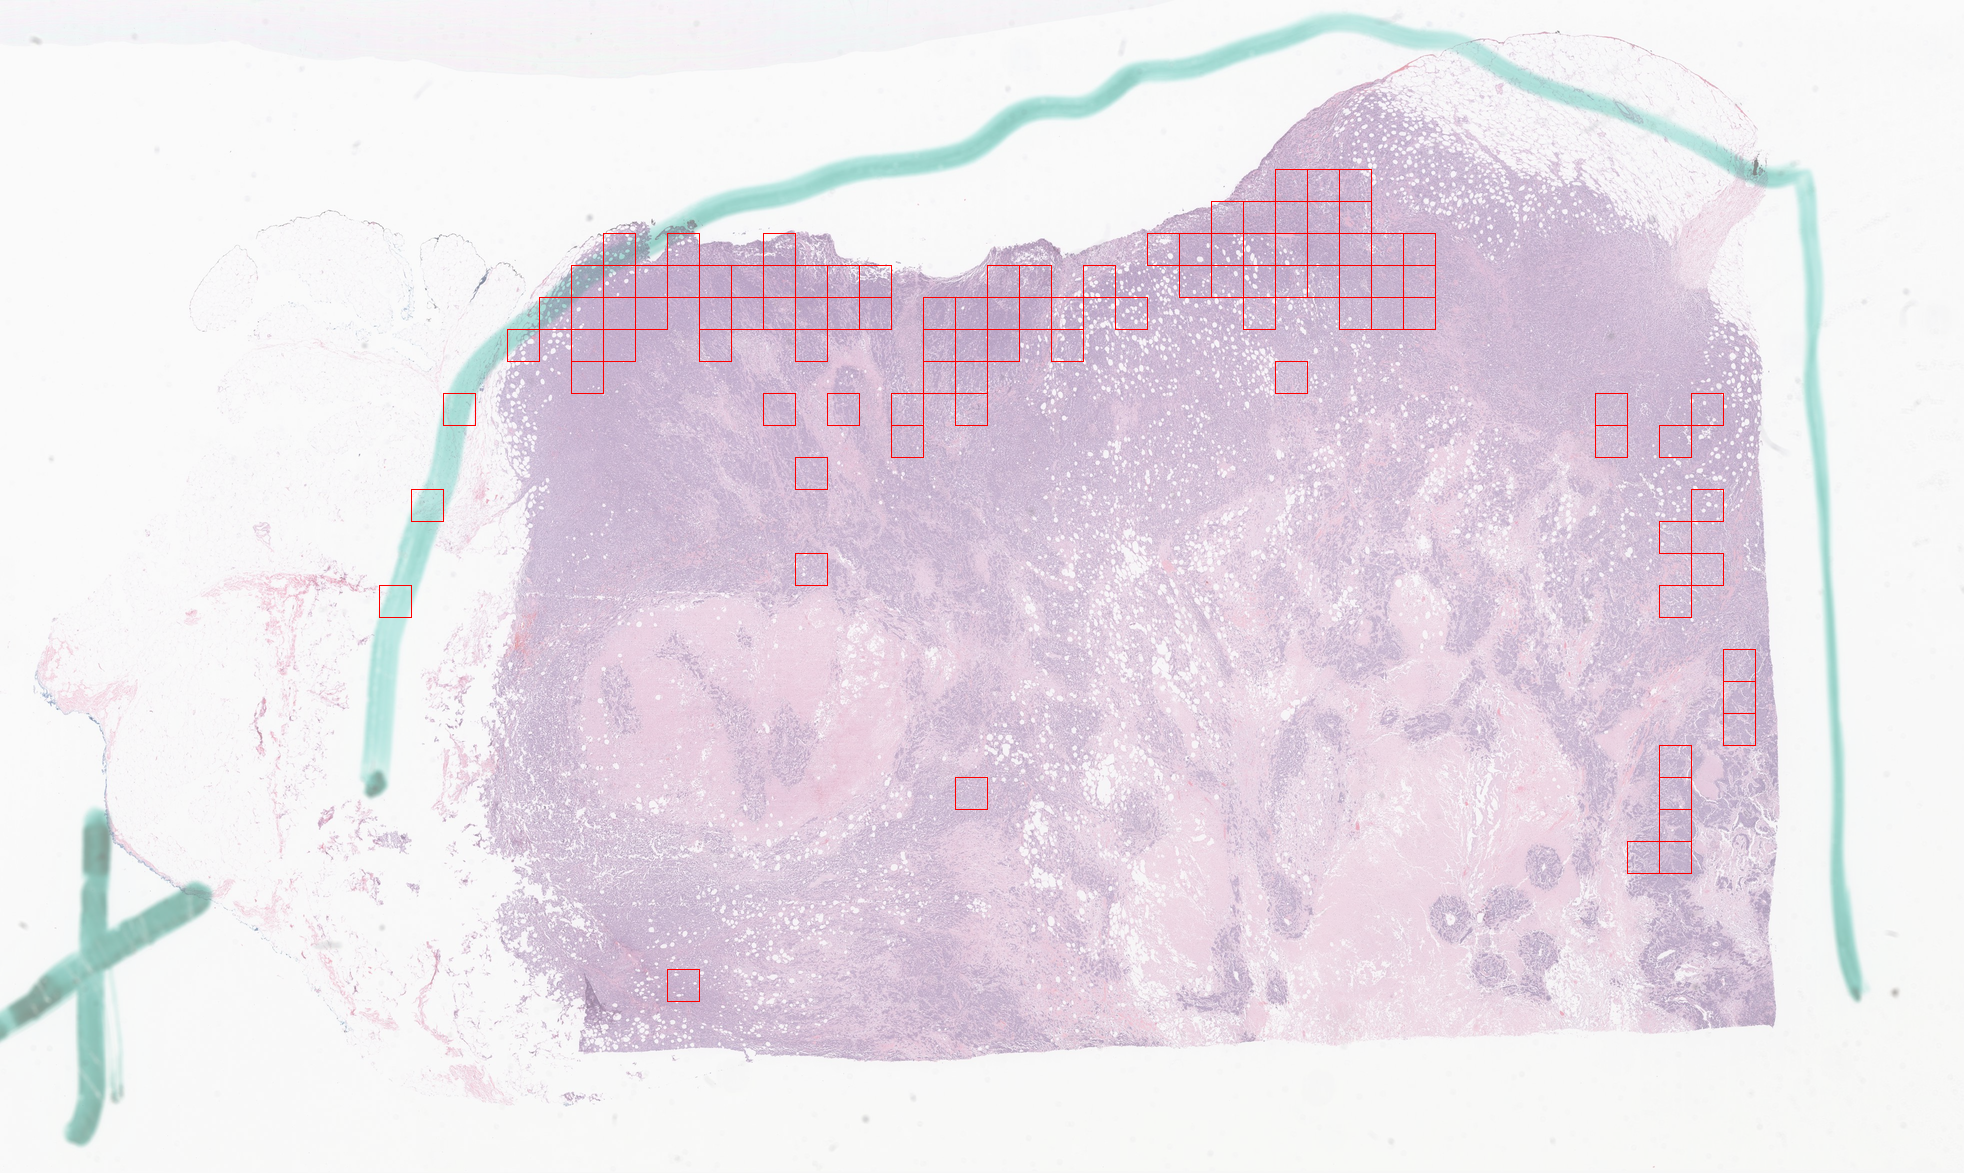

In [60]:
scored_tiles_extractor.locate_tiles(slide=reader)

In [94]:
import os
import numpy as np
import pandas as pd
from histolab.slide import Slide
from histolab.masks import BinaryMask
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import binary_dilation, remove_small_holes, remove_small_objects, disk
from skimage.measure import regionprops, label
from skimage.transform import resize
# Paths
data_path = '/lab/deasylab3/Jung/tiger/'
dir_TIFF_images = os.path.join(data_path, "wsirois/wsi-level-annotations/images/")
imgs_names = sorted([f for f in os.listdir(dir_TIFF_images) if f.startswith('TCGA')])

# Custom tissue mask class
class CustomTissueMask(BinaryMask):
    def _mask(self, slide):
        thumb_rgb = np.array(slide.thumbnail)
        gray = rgb2gray(thumb_rgb)
        thresh = threshold_otsu(gray)
        binary = gray < thresh
        dilated = binary_dilation(binary, selem=disk(3))
        no_holes = remove_small_holes(dilated, area_threshold=500)
        cleaned = remove_small_objects(no_holes, min_size=1000)
        resized_mask = resize(
            cleaned.astype(np.uint8),
            slide.dimensions[::-1],
            order=0, preserve_range=True, anti_aliasing=False
        ).astype(np.uint8)
        return resized_mask

# Prepare result list
results = []

for img_name in imgs_names:
    wsi_path = os.path.join(dir_TIFF_images, img_name)
    print(f"Processing: {img_name}")
    try:
        slide = Slide(wsi_path, processed_path="processed")
        mask = CustomTissueMask()
        final_mask = mask(slide)

        # Resize mask to thumbnail size
        thumbnail = np.array(slide.thumbnail)
        mask_resized = resize(
            final_mask,
            thumbnail.shape[:2],
            order=0,
            preserve_range=True,
            anti_aliasing=False
        ).astype(bool)

        # Bounding box
        labeled = label(mask_resized)
        props = regionprops(labeled)
        if props:
            largest_region = max(props, key=lambda x: x.area)
            minr, minc, maxr, maxc = largest_region.bbox
        else:
            minr = minc = maxr = maxc = 0

        # Scale bounding box to full-res
        W, H = slide.dimensions
        thumb_h, thumb_w = thumbnail.shape[:2]
        scale_x = W / thumb_w
        scale_y = H / thumb_h

        x_min = int(minc * scale_x)
        y_min = int(minr * scale_y)
        x_max = int(maxc * scale_x)
        y_max = int(maxr * scale_y)

        results.append({
            "filename": img_name,
            "x_min": x_min,
            "y_min": y_min,
            "x_max": x_max,
            "y_max": y_max
        })

    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        results.append({
            "filename": img_name,
            "x_min": -1,
            "y_min": -1,
            "x_max": -1,
            "y_max": -1
        })

# Save to CSV
df = pd.DataFrame(results)
output_csv_path = os.path.join(data_path, "bounding_boxes.csv")
df.to_csv(output_csv_path, index=False)
print(f"Saved bounding boxes to: {output_csv_path}")


Processing: TCGA-A1-A0SK-01Z-00-DX1.A44D70FA-4D96-43F4-9DD7-A61535786297.tif


/tmp/ipykernel_4132180/2664411203.py:23: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  dilated = binary_dilation(binary, selem=disk(3))


Processing: TCGA-A1-A0SP-01Z-00-DX1.20D689C6-EFA5-4694-BE76-24475A89ACC0.tif
Processing: TCGA-A2-A04P-01Z-00-DX1.5B481E02-D269-4732-8FDD-6494E6EE2B71.tif
Processing: TCGA-A2-A04Q-01Z-00-DX1.DF7ED6B6-7701-486D-9007-F26B6F0682C4.tif
Processing: TCGA-A2-A04T-01Z-00-DX1.71444266-BD56-4183-9603-C7AC20C9DA1E.tif
Processing: TCGA-A2-A0CM-01Z-00-DX1.AC4901DE-4B6D-4185-BB9F-156033839828.tif
Processing: TCGA-A2-A0D0-01Z-00-DX1.4FF6B8E5-703B-400F-920A-104F56E0F874.tif
Processing: TCGA-A2-A0D2-01Z-00-DX1.ECD890F5-BA01-4998-B472-7B683BD6D7B1.tif
Processing: TCGA-A2-A0ST-01Z-00-DX1.AE05A5DB-4861-40DE-B0F5-7955FC903A96.tif
Processing: TCGA-A2-A0SX-01Z-00-DX1.219A994C-8974-4458-98FA-FB1F14868E04.tif
Processing: TCGA-A2-A0T0-01Z-00-DX1.51F904DA-A4B5-4451-8AEF-58E7EF7651DB.tif
Processing: TCGA-A2-A0T2-01Z-00-DX1.29A5C4C8-6AE8-44EE-98C2-ACBCBFBE9D60.tif
Processing: TCGA-A2-A0YE-01Z-00-DX1.8A2E3094-5755-42BC-969D-7F0A2ECA0F39.tif
Processing: TCGA-A2-A0YM-01Z-00-DX1.A48B4C96-2CC5-464C-98B7-F0F92AE56533.tif